<a href="https://colab.research.google.com/github/AlexCuozzo/Unsupervised-Learning-By-Competing-Hidden-Units/blob/master/competing_hidden_units.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Datasets: MNIST and CIFAR-10

In [ ]:
  
import scipy.io, os
import numpy as np
import matplotlib.pyplot as plt

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [ ]:
import tensorflow as tf
mnist  = tf.keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data() #load data
mnist_train_x, mnist_test_x = torch.tensor(mnist_train_x.reshape(-1, 28*28, order="F")/255, dtype=torch.float), torch.tensor(mnist_test_x.reshape(-1, 28*28, order="F")/255, dtype=torch.float)
mnist_train_y, mnist_test_y = torch.tensor(mnist_train_y), torch.tensor(mnist_test_y)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
cifar10  = tf.keras.datasets.cifar10
(cifar10_train_x_raw, cifar10_train_y_raw), (cifar10_test_x_raw, cifar10_test_y_raw) = cifar10.load_data() #load data
cifar10_train_x, cifar10_test_x = torch.tensor(cifar10_train_x_raw.reshape(-1, 32*32*3, order="F")/255, dtype=torch.float), torch.tensor(cifar10_test_x_raw.reshape(-1, 32*32*3, order="F")/255, dtype=torch.float)
cifar10_train_y, cifar10_test_y = torch.tensor(cifar10_train_y_raw), torch.tensor(cifar10_test_y_raw)

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
fashion_mnist  = tf.keras.datasets.fashion_mnist
(fashion_mnist_train_x, fashion_mnist_train_y), (fashion_mnist_test_x, fashion_mnist_test_y) = fashion_mnist.load_data() #load data
fashion_mnist_train_x, fashion_mnist_test_x = torch.tensor(fashion_mnist_train_x.reshape(-1, 28*28, order="F")/255, dtype=torch.float), torch.tensor(fashion_mnist_test_x.reshape(-1, 28*28, order="F")/255, dtype=torch.float)
fashion_mnist_train_y, fashion_mnist_test_y = torch.tensor(fashion_mnist_train_y), torch.tensor(fashion_mnist_test_y)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
def get_unsupervised_weights(X, n_hidden, n_epochs, batch_size, prev_weights = None,
        learning_rate=2e-2, precision=1e-30, anti_hebbian_learning_strength=0.4, lebesgue_norm=2.0, rank=2, skip=1):
    sample_sz = X.shape[1]    
    if prev_weights is not None:
      weights = prev_weights.cuda()
    else:
      weights = torch.rand((n_hidden, sample_sz), dtype=torch.float).cuda()
    all_weights = torch.zeros((n_epochs*(X.shape[0]//batch_size)//skip + 1, n_hidden, sample_sz), dtype=torch.float)
    a_w_i = 0
    for epoch in range(n_epochs):    
        eps = learning_rate * (1 - epoch / n_epochs)        
        shuffled_epoch_data = X[torch.randperm(X.shape[0]),:]
        for i in range(X.shape[0] // batch_size):
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].cuda()            
            mini_batch = torch.transpose(mini_batch, 0, 1)            
            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)        
            tot_input=torch.mm(W, mini_batch)            
            
            y = torch.argsort(tot_input, dim=0)            
            yl = torch.zeros((n_hidden, batch_size), dtype = torch.float).cuda()
            yl[y[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl[y[n_hidden-rank], torch.arange(batch_size)] =- anti_hebbian_learning_strength            
                    
            xx = torch.sum(yl * tot_input,1)            
            xx = xx.unsqueeze(1)                    
            xx = xx.repeat(1, sample_sz)                            
            ds = torch.mm(yl, torch.transpose(mini_batch, 0, 1)) - xx * weights            
            
            nc = torch.max(torch.abs(ds))            
            if nc < precision:
              nc = precision            
            weights += eps*(ds/nc)
            if a_w_i % skip == 0:
              all_weights[a_w_i//skip] = weights
            a_w_i += 1
        print("Done: " + str(epoch))
    return all_weights


In [ ]:
# def animate_unsupervised_weights(all_weights, n_hidden, n_epochs, batch_size, n_rows, n_cols, dimensions, dataset_name, starting_from = 0, cmap=None):
#     all_weights = all_weights.cpu().numpy().reshape((-1, n_hidden,)+dimensions)
#     if n_rows*n_cols < n_hidden:
#       all_weights = 
#     fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
#     plt.axis('off')
#     for ax in axs.flatten():
#       ax.axis("off")
#     def animate(i):
#       weights = all_weights[i]
#       nc=np.amax(np.absolute(weights))
#       plt.suptitle("Unsupervised Weights: "+dataset_name + "\n Iteration:"+str(starting_from + i))
#       for row in range(len(axs)):
#         for col in range(len(axs[row])):
#           if cmap is not None:
#             axs[row][col].imshow(weights[row*axs.shape[1]+col],cmap=cmap, vmin=-nc, vmax=nc)
#           else:
#             axs[row][col].imshow(weights[row*axs.shape[1]+col],cmap=cmap, vmin=-nc, vmax=nc)
#       print(str(i) + " of " + str(len(all_weights)))
#       return fig, axs

#     anim = animation.FuncAnimation(fig, animate, frames=all_weights.shape[0])
#     anim.save(dataset_name + "_" + str(n_hidden) + "h_" + str(n_epochs)+"e_" + str(batch_size) + "bs" +".mp4")

def animate_unsupervised_weights(all_weights, n_hidden, n_epochs, batch_size, n_rows, n_cols, dimensions, dataset_name, starting_from = 0, cmap=None):
    all_weights = all_weights.cpu().numpy().reshape((-1, n_hidden,)+dimensions, order="F")
    fig = plt.figure(figsize=(10, 6))
    plt.axis('off')
    if n_rows*n_cols < n_hidden:
      all_weights = all_weights[:, np.random.choice(all_weights.shape[1], n_rows*n_cols, replace=False)]
    if len(dimensions) == 3:
      HM = np.zeros((n_rows*dimensions[0], n_cols*dimensions[1], dimensions[2]))
    else:
      HM  = np.zeros((n_rows*dimensions[0], n_cols*dimensions[1]))
    def animate(i):
      weights = all_weights[i]
      nc=np.amax(np.absolute(weights))
      for idx in range(n_cols * n_rows):
        x, y = idx % n_cols, idx // n_cols
        ma = weights[idx].max()
        mi = weights[idx].min()
        if len(dimensions) > 2:
          HM[y*dimensions[0]:(y+1)*dimensions[0],x*dimensions[1]:(x+1)*dimensions[1]]= (weights[idx] - mi)/(ma - mi)
        else:
          HM[y*dimensions[0]:(y+1)*dimensions[0],x*dimensions[1]:(x+1)*dimensions[1]]= weights[idx]
      plt.clf()
      nc=np.amax(np.absolute(HM))
      if cmap is not None:
        im=plt.imshow(HM, cmap=cmap, vmin=-nc, vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
      else:
        im = plt.imshow(HM)
      fig.canvas.draw()
      plt.title("Unsupervised Weights: "+dataset_name + "\n Hidden Units: "+str(n_hidden) + " ("+str(n_rows*n_cols)+" shown)"+"\n Iteration:"+str(starting_from + i))
      print("Done: " + str(i) + " of " + str(len(all_weights)))      
      return fig

    anim = animation.FuncAnimation(fig, animate, frames=all_weights.shape[0])
    anim.save(dataset_name + "_" + str(n_hidden) + "h_" + str(n_epochs)+"e_" + str(batch_size) + "bs" +".mp4")

In [ ]:
def train_and_animate(train_data, n_epochs, n_hidden, batch_size, n_rows, n_cols, dimensions, dataset_name, prev_weights = None, starting_from = 0, skip=1, cmap=None):
  all_weights = get_unsupervised_weights(train_data, n_hidden=n_hidden, n_epochs=n_epochs, batch_size=batch_size, prev_weights = prev_weights, skip=skip)
  try:
    if cmap is not None:
      animate_unsupervised_weights(all_weights, n_hidden, n_epochs, batch_size, n_rows, n_cols, dimensions, dataset_name, starting_from, cmap=cmap)
    else:
      animate_unsupervised_weights(all_weights, n_hidden, n_epochs, batch_size, n_rows, n_cols, dimensions, dataset_name, starting_from)
  except:
    return all_weights, -1
  return all_weights, starting_from+len(all_weights)

In [ ]:
cifar10_weights, iteration = train_and_animate(cifar10_train_x, 50, 100, 100, 10, 10, (32, 32, 3), "CIFAR10", skip=50)

In [ ]:
mnist_weights, iteration = train_and_animate(mnist_train_x, 2, 100, 100, 10, 10, (28, 28), "MNIST", skip=10, cmap="bwr")

In [ ]:
cifar10_weights_lg, iteration = train_and_animate(cifar10_train_x, 30, 1600, 100, 10, 10, (32, 32, 3), "CIFAR10", skip=50)

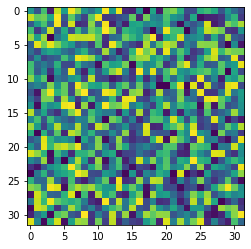

In [ ]:
animate_unsupervised_weights(cifar10_weights, 100, 50, 101, 10, 10, (32, 32, 3), "test_adsfasdf2")

In [ ]:
mnist_weights_2, iteration = train_and_animate(mnist_train_x, 2, 1600, 100, 10, 10, (28, 28), "MNIST_TOO_MANY_HIDDEN", skip=10, cmap="bwr")

In [ ]:
cifar10_weights_2, iteration = train_and_animate(cifar10_train_x, 29, 64, 100, 8, 8, (32, 32, 3), "CIFAR10", skip=50)

In [ ]:
cifar10_weights_3, iteration = train_and_animate(cifar10_train_x, 10, 100, 4, 10, 10, (32, 32, 3), "CIFAR10", skip=50*25)

In [ ]:
cifar10_weights_3, iteration = train_and_animate(cifar10_train_x, 10, 400, 4, 10, 10, (32, 32, 3), "CIFAR10-lots_of-hidden-batch-small-hidden", skip=50*5)

In [ ]:
final_weights_cifar_10 = cifar10_weights_3[-2]

In [ ]:
augmented_train_cifar_10_400h = torch.mm(cifar10_train_x, final_weights_cifar_10.t())
augmented_test_cifar_10_400h = torch.mm(cifar10_test_x, final_weights_cifar_10.t())

In [ ]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [ ]:
#testing good cifar10 bio model vs standard
standard_cifar10_model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(3072,)),                   
    keras.layers.Dense(10, activation="softmax")
])
standard_cifar10_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_standard_cifar10 = standard_cifar10_model.fit(cifar10_train_x, cifar10_train_y, batch_size=256, epochs=20, validation_data=(cifar10_test_x, cifar10_test_y))

In [ ]:
bio_cifar10_model = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(400, ), activation="softmax")
])
bio_cifar10_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_bio_cifar10 = bio_cifar10_model.fit(augmented_train_cifar_10_400h, cifar10_train_y, batch_size=256, epochs=20, validation_data=(augmented_test_cifar_10_400h, cifar10_test_y))

In [ ]:
def compare_models(history_standard, history_bio):
  fig = plt.figure(figsize=(8, 8))
  for metric in ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]:
    plt.plot(history_standard.history[metric], label="ANN_"+metric)
    plt.plot(history_bio.history[metric], label="BIO_"+metric)
  plt.legend()
  plt.show()

In [ ]:
compare_models(history_standard_cifar10, history_bio_cifar10)

In [ ]:
mnist_weights, iteration = train_and_animate(mnist_train_x, 2, 400, 100, 10, 10, (28, 28), "MNIST", skip=10, cmap="bwr")

In [ ]:
final_weights_mnist = mnist_weights[-2]

In [ ]:
augmented_train_mnist = torch.mm(mnist_train_x, final_weights_mnist.t())
augmented_test_mnist = torch.mm(mnist_test_x, final_weights_mnist.t())

In [ ]:
#testing good cifar10 bio model vs standard
standard_mnist_model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(28*28,)),                   
    keras.layers.Dense(10, activation="softmax")
])
standard_mnist_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_standard_mnist = standard_mnist_model.fit(mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(mnist_test_x, mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4562 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.2999 - val_sparse_categorical_accuracy: 0.9133
Epoch 2/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.2943 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.9223
Epoch 3/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2783 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.2818 - val_sparse_categorical_accuracy: 0.9192
Epoch 4/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.2717 - val_sparse_categorical_accuracy: 0.9262
Epoch 5/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.2724 - val_sparse_categorical_accuracy: 0.9252
Epoch 6/20
60000/60000 [=

In [ ]:
bio_mnist_model = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(100, ), activation="softmax")
])
bio_mnist_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_bio_mnist = bio_mnist_model.fit(augmented_train_mnist, mnist_train_y, batch_size=256, epochs=20, validation_data=(augmented_test_mnist, mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 12us/step - loss: 1.9897 - sparse_categorical_accuracy: 0.4013 - val_loss: 1.1150 - val_sparse_categorical_accuracy: 0.6482
Epoch 2/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.9569 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7634
Epoch 3/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.7549 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.8038
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.6628 - sparse_categorical_accuracy: 0.8083 - val_loss: 0.5995 - val_sparse_categorical_accuracy: 0.8301
Epoch 5/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.6068 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.5559 - val_sparse_categorical_accuracy: 0.8422
Epoch 6/20
60000/60000 [=

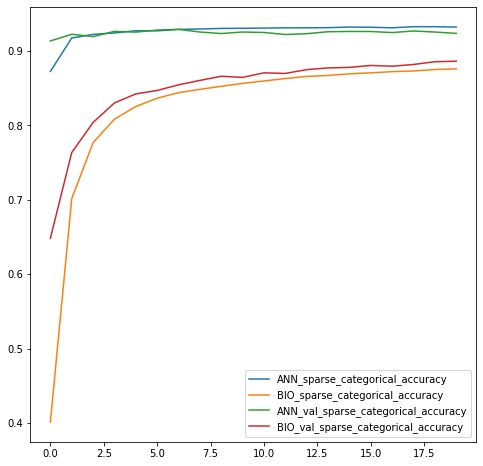

In [ ]:
compare_models(history_standard_mnist, history_bio_mnist)

Done: 0
Done: 1
Done: 2
Done: 3
Done: 4
Done: 0 of 121
Done: 0 of 121
Done: 1 of 121
Done: 2 of 121
Done: 3 of 121
Done: 4 of 121
Done: 5 of 121
Done: 6 of 121
Done: 7 of 121
Done: 8 of 121
Done: 9 of 121
Done: 10 of 121
Done: 11 of 121
Done: 12 of 121
Done: 13 of 121
Done: 14 of 121
Done: 15 of 121
Done: 16 of 121
Done: 17 of 121
Done: 18 of 121
Done: 19 of 121
Done: 20 of 121
Done: 21 of 121
Done: 22 of 121
Done: 23 of 121
Done: 24 of 121
Done: 25 of 121
Done: 26 of 121
Done: 27 of 121
Done: 28 of 121
Done: 29 of 121
Done: 30 of 121
Done: 31 of 121
Done: 32 of 121
Done: 33 of 121
Done: 34 of 121
Done: 35 of 121
Done: 36 of 121
Done: 37 of 121
Done: 38 of 121
Done: 39 of 121
Done: 40 of 121
Done: 41 of 121
Done: 42 of 121
Done: 43 of 121
Done: 44 of 121
Done: 45 of 121
Done: 46 of 121
Done: 47 of 121
Done: 48 of 121
Done: 49 of 121
Done: 50 of 121
Done: 51 of 121
Done: 52 of 121
Done: 53 of 121
Done: 54 of 121
Done: 55 of 121
Done: 56 of 121
Done: 57 of 121
Done: 58 of 121
Done: 59 of

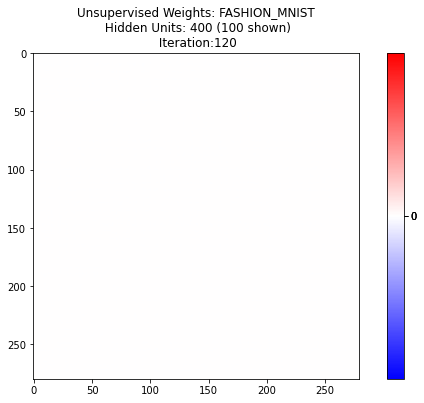

In [ ]:
fashion_mnist_weights, iteration = train_and_animate(fashion_mnist_train_x, 5, 400, 50, 10, 10, (28, 28), "FASHION_MNIST", skip=50, cmap="bwr")

In [ ]:
final_weights_fashion_mnist = fashion_mnist_weights[-2]
augmented_train_fashion_mnist_x = torch.mm(fashion_mnist_train_x, final_weights_fashion_mnist.t())
augmented_test_fashion_mnist_x = torch.mm(fashion_mnist_test_x, final_weights_fashion_mnist.t())

In [ ]:
#testing good cifar10 bio model vs standard
standard_fashion_mnist_model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(28*28,)),                   
    keras.layers.Dense(10, activation="softmax")
])
standard_fashion_mnist_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_standard_fashion_mnist = standard_fashion_mnist_model.fit(fashion_mnist_train_x, fashion_mnist_train_y, batch_size=256, epochs=20, validation_data=(fashion_mnist_test_x, fashion_mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.5953 - sparse_categorical_accuracy: 0.7930 - val_loss: 0.5077 - val_sparse_categorical_accuracy: 0.8257
Epoch 2/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4650 - sparse_categorical_accuracy: 0.8397 - val_loss: 0.4863 - val_sparse_categorical_accuracy: 0.8309
Epoch 3/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4329 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4680 - val_sparse_categorical_accuracy: 0.8356
Epoch 4/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4251 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.4705 - val_sparse_categorical_accuracy: 0.8372
Epoch 5/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4157 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.4549 - val_sparse_categorical_accuracy: 0.8420
Epoch 6/20
60000/60000 [=

In [ ]:
bio_fashion_mnist_model = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(400, ), activation="softmax")
])
bio_fashion_mnist_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_bio_fashion_mnist = bio_fashion_mnist_model.fit(augmented_train_fashion_mnist_x, fashion_mnist_train_y, batch_size=256, epochs=20, validation_data=(augmented_test_fashion_mnist_x, fashion_mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 14us/step - loss: 1.4287 - sparse_categorical_accuracy: 0.5446 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.6353
Epoch 2/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.9181 - sparse_categorical_accuracy: 0.6618 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.6574
Epoch 3/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.8458 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.8441 - val_sparse_categorical_accuracy: 0.6952
Epoch 4/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.8101 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.6912
Epoch 5/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.7878 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.7097
Epoch 6/20
60000/60000 [=

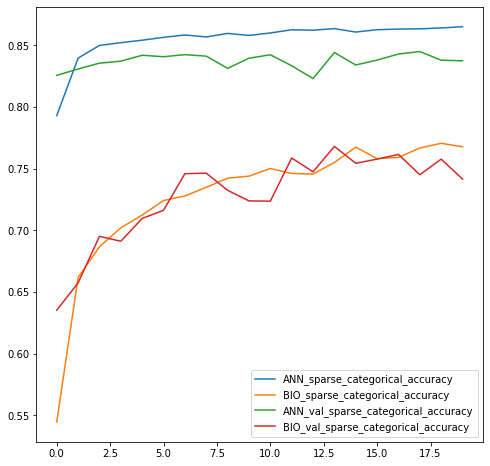

In [ ]:
compare_models(history_standard_fashion_mnist, history_bio_fashion_mnist)

Done: 0
Done: 1
Done: 0 of 121
Done: 0 of 121
Done: 1 of 121
Done: 2 of 121
Done: 3 of 121
Done: 4 of 121
Done: 5 of 121
Done: 6 of 121
Done: 7 of 121
Done: 8 of 121
Done: 9 of 121
Done: 10 of 121
Done: 11 of 121
Done: 12 of 121
Done: 13 of 121
Done: 14 of 121
Done: 15 of 121
Done: 16 of 121
Done: 17 of 121
Done: 18 of 121
Done: 19 of 121
Done: 20 of 121
Done: 21 of 121
Done: 22 of 121
Done: 23 of 121
Done: 24 of 121
Done: 25 of 121
Done: 26 of 121
Done: 27 of 121
Done: 28 of 121
Done: 29 of 121
Done: 30 of 121
Done: 31 of 121
Done: 32 of 121
Done: 33 of 121
Done: 34 of 121
Done: 35 of 121
Done: 36 of 121
Done: 37 of 121
Done: 38 of 121
Done: 39 of 121
Done: 40 of 121
Done: 41 of 121
Done: 42 of 121
Done: 43 of 121
Done: 44 of 121
Done: 45 of 121
Done: 46 of 121
Done: 47 of 121
Done: 48 of 121
Done: 49 of 121
Done: 50 of 121
Done: 51 of 121
Done: 52 of 121
Done: 53 of 121
Done: 54 of 121
Done: 55 of 121
Done: 56 of 121
Done: 57 of 121
Done: 58 of 121
Done: 59 of 121
Done: 60 of 121
Don

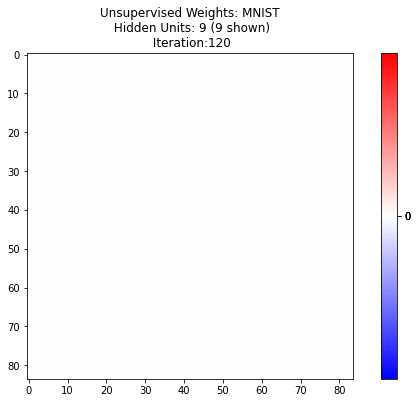

In [ ]:
mnist_weights_small, iteration = train_and_animate(mnist_train_x, 2, 9, 10, 3, 3, (28, 28), "MNIST", skip=100, cmap="bwr")

In [ ]:
final_weights_mnist_small = mnist_weights_small[-2]
augmented_train_mnist_small_x = torch.mm(mnist_train_x, final_weights_mnist_small.t())
augmented_test_mnist_small_x = torch.mm(mnist_test_x, final_weights_mnist_small.t())

In [ ]:
#testing good cifar10 bio model vs standard
standard_mnist_model_small = keras.Sequential([
    keras.layers.Dense(9, input_shape=(28*28,)),                   
    keras.layers.Dense(10, activation="softmax")
])
standard_mnist_model_small.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_standard_mnist_small = standard_mnist_model_small.fit(mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(mnist_test_x, mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.9399 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.4582 - val_sparse_categorical_accuracy: 0.8752
Epoch 2/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8868 - val_loss: 0.3439 - val_sparse_categorical_accuracy: 0.9008
Epoch 3/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3412 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.3103 - val_sparse_categorical_accuracy: 0.9105
Epoch 4/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3137 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.2956 - val_sparse_categorical_accuracy: 0.9153
Epoch 5/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.2976 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.2868 - val_sparse_categorical_accuracy: 0.9195
Epoch 6/20
60000/60000 [=

In [ ]:
bio_mnist_model_small = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(9, ), activation="softmax")
])
bio_mnist_model_small.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_bio_mnist_small = bio_mnist_model_small.fit(augmented_train_mnist_small_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(augmented_test_mnist_small_x, mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 12us/step - loss: 3.6387 - sparse_categorical_accuracy: 0.0656 - val_loss: 2.6705 - val_sparse_categorical_accuracy: 0.0931
Epoch 2/20
60000/60000 [==============================] - 1s 11us/step - loss: 2.4018 - sparse_categorical_accuracy: 0.1220 - val_loss: 2.1506 - val_sparse_categorical_accuracy: 0.1726
Epoch 3/20
60000/60000 [==============================] - 1s 11us/step - loss: 1.9739 - sparse_categorical_accuracy: 0.2859 - val_loss: 1.7814 - val_sparse_categorical_accuracy: 0.4263
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 1.6759 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.5319 - val_sparse_categorical_accuracy: 0.5711
Epoch 5/20
60000/60000 [==============================] - 1s 11us/step - loss: 1.4698 - sparse_categorical_accuracy: 0.5875 - val_loss: 1.3596 - val_sparse_categorical_accuracy: 0.6216
Epoch 6/20
60000/60000 [=

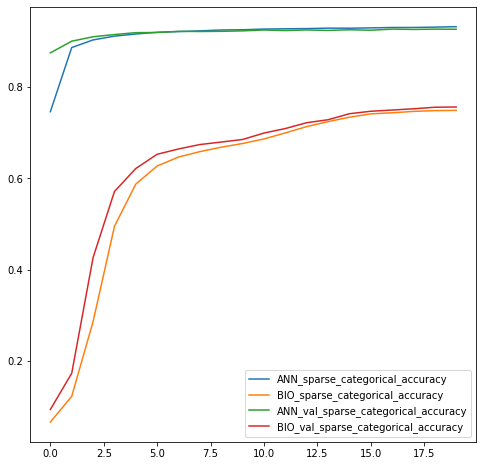

In [ ]:
compare_models(history_standard_mnist_small, history_bio_mnist_small)

In [ ]:
def get_unsupervised_weights_2(X, n_hidden, n_epochs, batch_size, prev_weights = None,
        learning_rate=2e-2, precision=1e-30, anti_hebbian_learning_strength=0.4, lebesgue_norm=2.0, rank=2):
    sample_sz = X.shape[1]    
    weights = torch.rand((n_hidden, sample_sz), dtype=torch.float).cuda()
    for epoch in range(n_epochs):    
        eps = learning_rate * (1 - epoch / n_epochs)        
        shuffled_epoch_data = X[torch.randperm(X.shape[0]),:]
        for i in range(X.shape[0] // batch_size):
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].cuda()            
            mini_batch = torch.transpose(mini_batch, 0, 1)            
            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)        
            tot_input=torch.mm(W, mini_batch)            
            
            y = torch.argsort(tot_input, dim=0)            
            yl = torch.zeros((n_hidden, batch_size), dtype = torch.float).cuda()
            yl[y[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl[y[n_hidden-rank], torch.arange(batch_size)] =- anti_hebbian_learning_strength            
                    
            xx = torch.sum(yl * tot_input,1)            
            xx = xx.unsqueeze(1)                    
            xx = xx.repeat(1, sample_sz)                            
            ds = torch.mm(yl, torch.transpose(mini_batch, 0, 1)) - xx * weights            
            
            nc = torch.max(torch.abs(ds))            
            if nc < precision:
              nc = precision            
            weights += eps*(ds/nc)
        print("Done: " + str(epoch))
    return weights.cpu()


def get_final_mnist_weights(n_hidden):
  return get_unsupervised_weights_2(mnist_train_x, n_hidden, 10, 50)

In [ ]:
def train_standard_mnist_model(n_hidden):
  #testing good cifar10 bio model vs standard
  model = keras.Sequential([
      keras.layers.Dense(n_hidden, input_shape=(28*28,)),                   
      keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
  history = model.fit(mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(mnist_test_x, mnist_test_y))
  return history.history

In [ ]:
def train_bio_mnist_model(n_hidden, final_mnist_weights):
  augmented_mnist_train_x = torch.mm(mnist_train_x, final_mnist_weights.t())
  augmented_mnist_test_x = torch.mm(mnist_test_x, final_mnist_weights.t())

  bio_model = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(n_hidden, ), activation="softmax")
])
  bio_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
  history_bio = bio_model.fit(augmented_mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(augmented_mnist_test_x, mnist_test_y))
  return history_bio.history

In [ ]:
fib = range(7, 13)
standard_val_accuracies = []
bio_val_accuracies = []

for n_hidden in fib:
  final_mnist_weights = get_final_mnist_weights(n_hidden)
  standard_history = train_standard_mnist_model(n_hidden)
  bio_history = train_bio_mnist_model(n_hidden, final_mnist_weights)
  standard_val_accuracies.append(standard_history["val_sparse_categorical_accuracy"])
  bio_val_accuracies.append(bio_history["val_sparse_categorical_accuracy"])

Done: 0
Done: 1
Done: 2
Done: 3
Done: 4
Done: 5
Done: 6
Done: 7
Done: 8
Done: 9
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 21us/step - loss: 1.0081 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.5624 - val_sparse_categorical_accuracy: 0.8425
Epoch 2/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.4930 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8832
Epoch 3/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.4002 - sparse_categorical_accuracy: 0.8866 - val_loss: 0.3621 - val_sparse_categorical_accuracy: 0.8983
Epoch 4/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.3370 - val_sparse_categorical_accuracy: 0.9043
Epoch 5/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.3362 - sparse_categorical_accuracy: 0.9055 - val_

In [ ]:
max_standard_val_accuracy = [i[-1] for i in standard_val_accuracies]
max_bio_val_accuracy = [i[-1] for i in bio_val_accuracies]

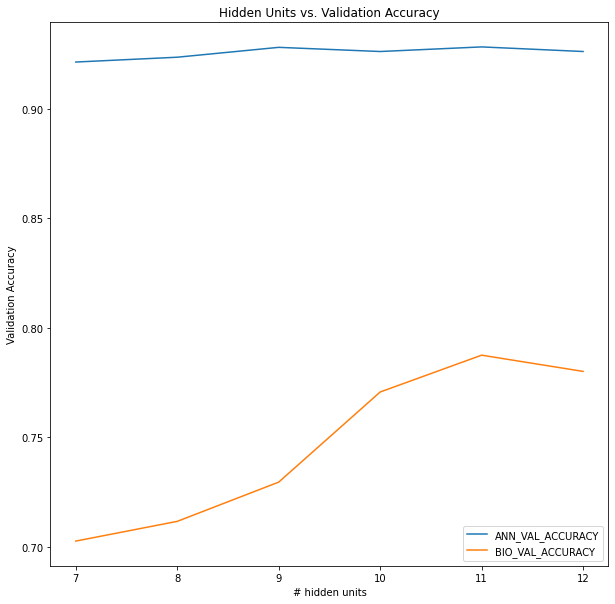

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(fib, max_standard_val_accuracy, label="ANN_VAL_ACCURACY")
plt.plot(fib, max_bio_val_accuracy, label="BIO_VAL_ACCURACY")
plt.xlabel("# hidden units")
plt.ylabel("Validation Accuracy")
plt.title("Hidden Units vs. Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
random_matrix = np.random.normal(0, 1, size=(1000, 784))
random_matrix_mnist_train_x = torch.mm(mnist_train_x, torch.tensor(random_matrix.T, dtype=torch.float))
random_matrix_mnist_test_x = torch.mm(mnist_test_x, torch.tensor(random_matrix.T, dtype=torch.float))
                                      

random_model = keras.Sequential([                   
    keras.layers.Dense(10, input_shape=(1000, ), activation="softmax")
])
random_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_random = random_model.fit(random_matrix_mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(random_matrix_mnist_test_x, mnist_test_y))

model = keras.Sequential([
      keras.layers.Dense(1000, input_shape=(28*28,)),                   
      keras.layers.Dense(10, activation="softmax")
  ])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_standard = model.fit(mnist_train_x, mnist_train_y, batch_size=256, epochs=20, validation_data=(mnist_test_x, mnist_test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 15us/step - loss: 1.5210 - sparse_categorical_accuracy: 0.8138 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.8798
Epoch 2/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.5985 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.5474 - val_sparse_categorical_accuracy: 0.8895
Epoch 3/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.5147 - sparse_categorical_accuracy: 0.8885 - val_loss: 0.5624 - val_sparse_categorical_accuracy: 0.8776
Epoch 4/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.4827 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.8882
Epoch 5/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.4577 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.4415 - val_sparse_categorical_accuracy: 0.9006
Epoch 6/20
60000/60000 [=

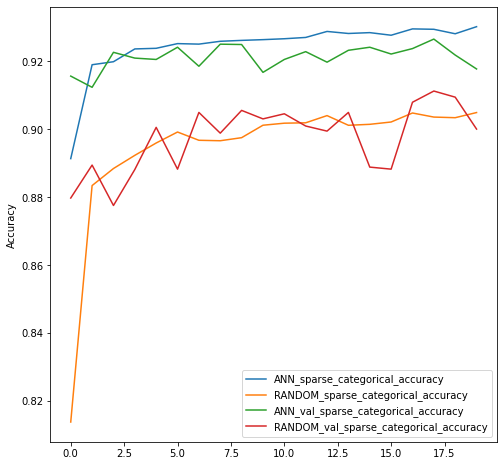

In [ ]:
fig = plt.figure(figsize=(8, 8))
for metric in ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]:
  plt.plot(history_standard.history[metric], label="ANN_"+metric)
  plt.plot(history_random.history[metric], label="RANDOM_"+metric)
plt.legend()
plt.ylabel("Accuracy")
plt.show()

Done: 0
Done: 1
Done: 0 of 301
Done: 0 of 301
Done: 1 of 301
Done: 2 of 301
Done: 3 of 301
Done: 4 of 301
Done: 5 of 301
Done: 6 of 301
Done: 7 of 301
Done: 8 of 301
Done: 9 of 301
Done: 10 of 301
Done: 11 of 301
Done: 12 of 301
Done: 13 of 301
Done: 14 of 301
Done: 15 of 301
Done: 16 of 301
Done: 17 of 301
Done: 18 of 301
Done: 19 of 301
Done: 20 of 301
Done: 21 of 301
Done: 22 of 301
Done: 23 of 301
Done: 24 of 301
Done: 25 of 301
Done: 26 of 301
Done: 27 of 301
Done: 28 of 301
Done: 29 of 301
Done: 30 of 301
Done: 31 of 301
Done: 32 of 301
Done: 33 of 301
Done: 34 of 301
Done: 35 of 301
Done: 36 of 301
Done: 37 of 301
Done: 38 of 301
Done: 39 of 301
Done: 40 of 301
Done: 41 of 301
Done: 42 of 301
Done: 43 of 301
Done: 44 of 301
Done: 45 of 301
Done: 46 of 301
Done: 47 of 301
Done: 48 of 301
Done: 49 of 301
Done: 50 of 301
Done: 51 of 301
Done: 52 of 301
Done: 53 of 301
Done: 54 of 301
Done: 55 of 301
Done: 56 of 301
Done: 57 of 301
Done: 58 of 301
Done: 59 of 301
Done: 60 of 301
Don

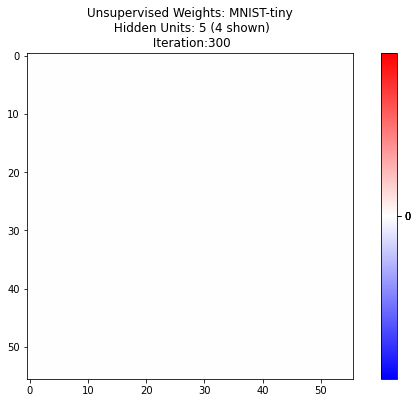

In [ ]:
mnist_weights_tiny, iteration = train_and_animate(mnist_train_x, 2, 5, 4, 2, 2, (28, 28), "MNIST-tiny", skip=100, cmap="bwr")